In [30]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../../preprocessed_dataset/preprocessed_dataset.csv.zip", compression='zip')

# df = df.sample(frac=.0005)

## Additional Metric Calculator

In [31]:
import numpy as np

def fowlkes_mallows_index(tp, fp, fn):
    """Calculate the Fowlkes-Mallows Index given true positives (tp), false positives (fp), and false negatives (fn)."""
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return np.sqrt(precision * recall)

def informedness(tp, fp, fn, tn):
    """Calculate Informedness given all confusion matrix components."""
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return sensitivity + specificity - 1

def markedness(tp, fp, fn, tn):
    """Calculate Markedness given all confusion matrix components."""
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0
    return precision + npv - 1

def youdens_j_index(tp, fp, fn, tn):
    """Calculate Youden's J index."""
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return sensitivity + specificity - 1

Fowlkes-Mallows Index: 0.8236877675803729
Informedness: 0.6400000000000001
Markedness: 0.641025641025641
Youden's J Index: 0.6400000000000001


## KNN MODEL GRIDSEARCH

Fitting 5 folds for each of 30 candidates, totalling 150 fits


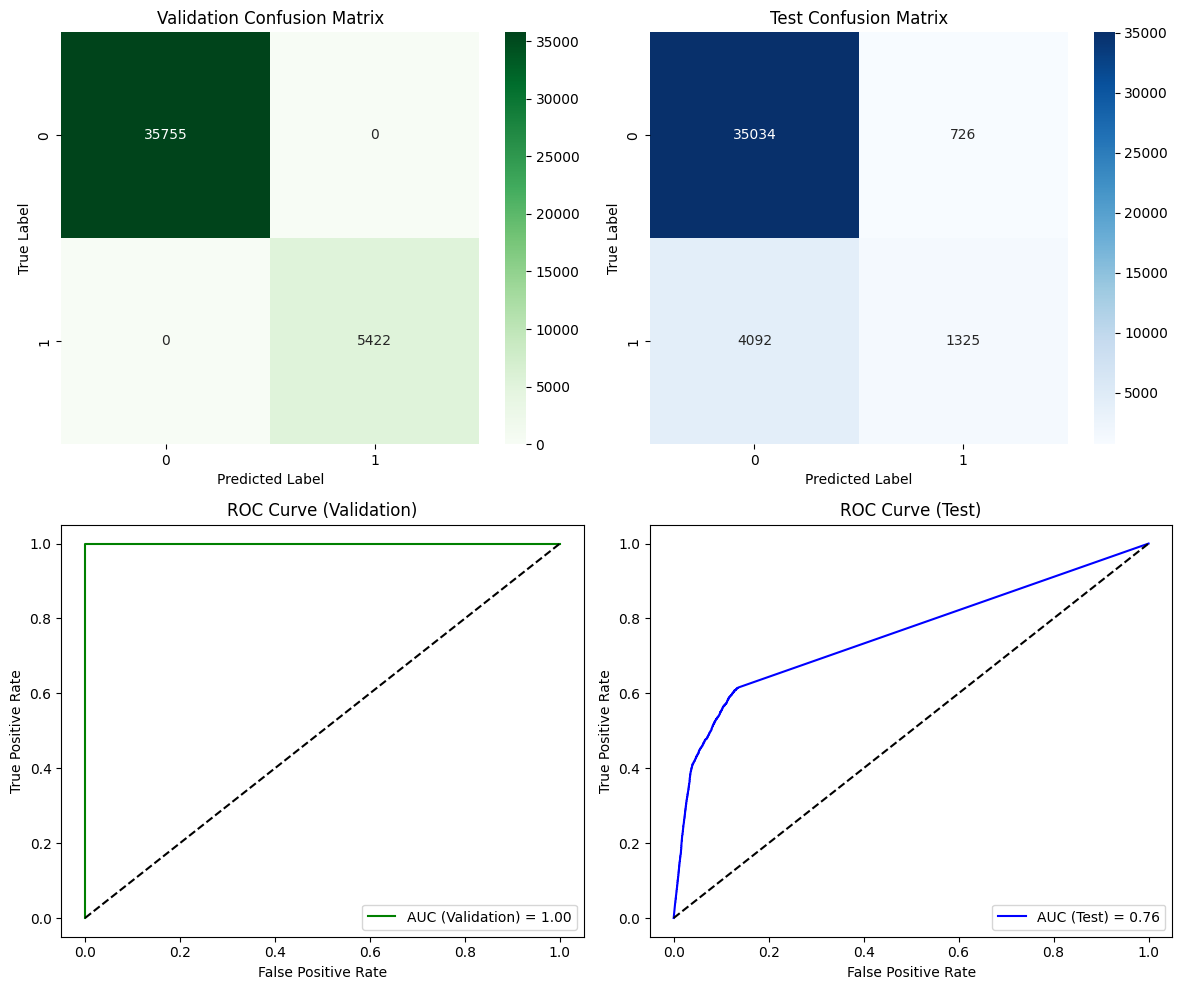

Best Hyperparameters: {'classifier__n_neighbors': 5, 'classifier__p': 3, 'classifier__weights': 'distance'} 

            Accuracy  Precision  Recall  F1 Score   AUC  Cohen's Kappa  \
Validation      1.00       1.00    1.00      1.00  1.00            1.0   
Test            0.88       0.65    0.24      0.35  0.76            0.3   

            Log Loss  fmi  informedness  markedness  youden j  
Validation      0.00  1.0          1.00        1.00      1.00  
Test            2.02  0.4          0.98        0.54      0.22  


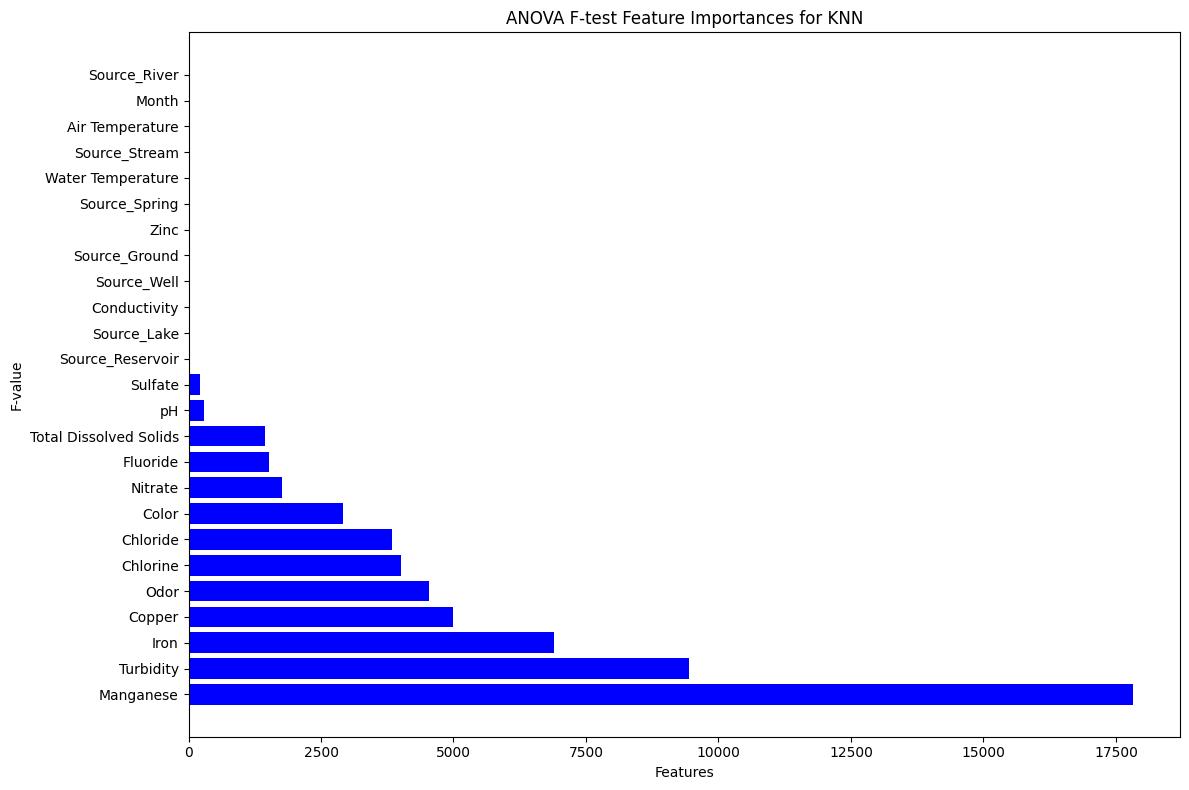

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Drop the 'Day' and 'Time of Day' columns from the DataFrame
KNN_df = df.drop(['Day', 'Time of Day', 'Index'], axis=1)

# Define features for different types of encoding
ordinal_features = ['Color', 'Month']
one_hot_features = ['Source']
numerical_features = KNN_df.columns.difference(['Target'] + ordinal_features + one_hot_features).tolist()

# Create transformers for each type of preprocessing
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # Default strategy is 'ordinal'
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a column transformer that applies the transformation to certain columns
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('onehot', categorical_transformer, one_hot_features),
    ('num', numerical_transformer, numerical_features)],
    remainder='passthrough'
)


# Create a pipeline that applies the preprocessor and then fits the KNN model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Define the hyperparameters grid
param_grid = {
    'classifier__n_neighbors': [5, 10, 15, 20, 25],
    'classifier__weights': ['uniform', 'distance'],  # Weighting of neighbors
    'classifier__p': [1, 2, 3]  # Range for Minkowski distance
}


# Split the dataset into features and the target
X = KNN_df.drop('Target', axis=1)
y = KNN_df['Target']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Perform grid search with cross-validation on the validation set, optimizing for F1 score
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_search.fit(X_val, y_val)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Plotting all figures in a 2x2 grid
plt.figure(figsize=(12, 10))

# Validation Confusion Matrix
plt.subplot(2, 2, 1)  # First plot in a 2x2 grid
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Test Confusion Matrix
plt.subplot(2, 2, 2)  # Second plot in a 2x2 grid
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Validation ROC Curve
plt.subplot(2, 2, 3)  # Third plot in a 2x2 grid
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr_val, tpr_val, label=f'AUC (Validation) = {roc_auc_score(y_val, y_val_prob):.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Test ROC Curve
plt.subplot(2, 2, 4)  # Fourth plot in a 2x2 grid
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr_test, tpr_test, label=f'AUC (Test) = {roc_auc_score(y_test, y_test_prob):.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()

plt.show()


# Calculate metrics for validation set
tn_val = cm_val[0, 0]
fp_val = cm_val[0, 1]
fn_val = cm_val[1, 0]
tp_val = cm_val[1, 1]


validation_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1 Score": f1_score(y_val, y_val_pred),
    "AUC": roc_auc_score(y_val, y_val_prob),
    "Cohen's Kappa": cohen_kappa_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_prob),
    "fmi": fowlkes_mallows_index(tp_val, fp_val, fn_val),
    "informedness": informedness(tp_val, fp_val, fn_val, tn_val),
    "markedness": markedness(tp_val, fp_val, fn_val, tn_val),
    "youden j": youdens_j_index(tp_val, fp_val, fn_val, tn_val)
}


# Calculate metrics for test set
tn_test = cm_test[0, 0]
fp_test = cm_test[0, 1]
fn_test = cm_test[1, 0]
tp_test = cm_test[1, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "AUC": roc_auc_score(y_test, y_test_prob),
    "Cohen's Kappa": cohen_kappa_score(y_test, y_test_pred),
    "Log Loss": log_loss(y_test, y_test_prob),
    "fmi": fowlkes_mallows_index(tp_test, fp_test, fn_test),
    "informedness": informedness(tp_test, fp_test, fn_val, tn_test),
    "markedness": markedness(tp_test, fp_test, fn_test, tn_test),
    "youden j": youdens_j_index(tp_test, fp_test, fn_test, tn_test)
}

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([validation_metrics, test_metrics], index=['Validation', 'Test'])


# Print the best hyperparameters and evaluation metrics
print("Best Hyperparameters:", best_params, "\n")
print(metrics_df.round(2))


def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer, including transformations and pipelines."""
    feature_names = []
    
    # Loop through each transformer in the column transformer
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'passthrough':
            # Append the feature names directly
            feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            # If a transformer has a 'get_feature_names_out', use it
            feature_names.extend(transformer.get_feature_names_out(columns))
        elif hasattr(transformer, 'named_steps'):
            last_step = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
            if hasattr(last_step, 'get_feature_names_out'):
                feature_names.extend(last_step.get_feature_names_out(columns))
            elif hasattr(last_step, 'get_feature_names'):
                feature_names.extend(last_step.get_feature_names(columns))
            else:
                feature_names.extend(columns)
        else:
            feature_names.extend(columns)

    return feature_names

import numpy as np

X_train_transformed = preprocessor.fit_transform(X_train)

# Now perform ANOVA F-test
f_values, p_values = f_classif(X_train_transformed, y_train)

transformed_feature_names = get_feature_names(preprocessor)

# Plotting the F-values
plt.figure(figsize=(12, 8))
ordering = np.argsort(f_values)[::-1]  # sort features by F-value
plt.title('ANOVA F-test Feature Importances for KNN')
plt.barh(np.array(transformed_feature_names)[ordering], f_values[ordering], color='blue')
plt.xlabel('Features')
plt.ylabel('F-value')
plt.tight_layout()
plt.show()




## KNN Model GridSearch with Feature Selection

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'classifier__n_neighbors': 5, 'classifier__p': 3, 'classifier__weights': 'distance'}
Evaluation Metrics:
Accuracy: 0.89
Precision: 0.65
Recall: 0.36
F1 Score: 0.46
Cohen's Kappa: 0.41
Log Loss: 1.55
AUC: 0.82


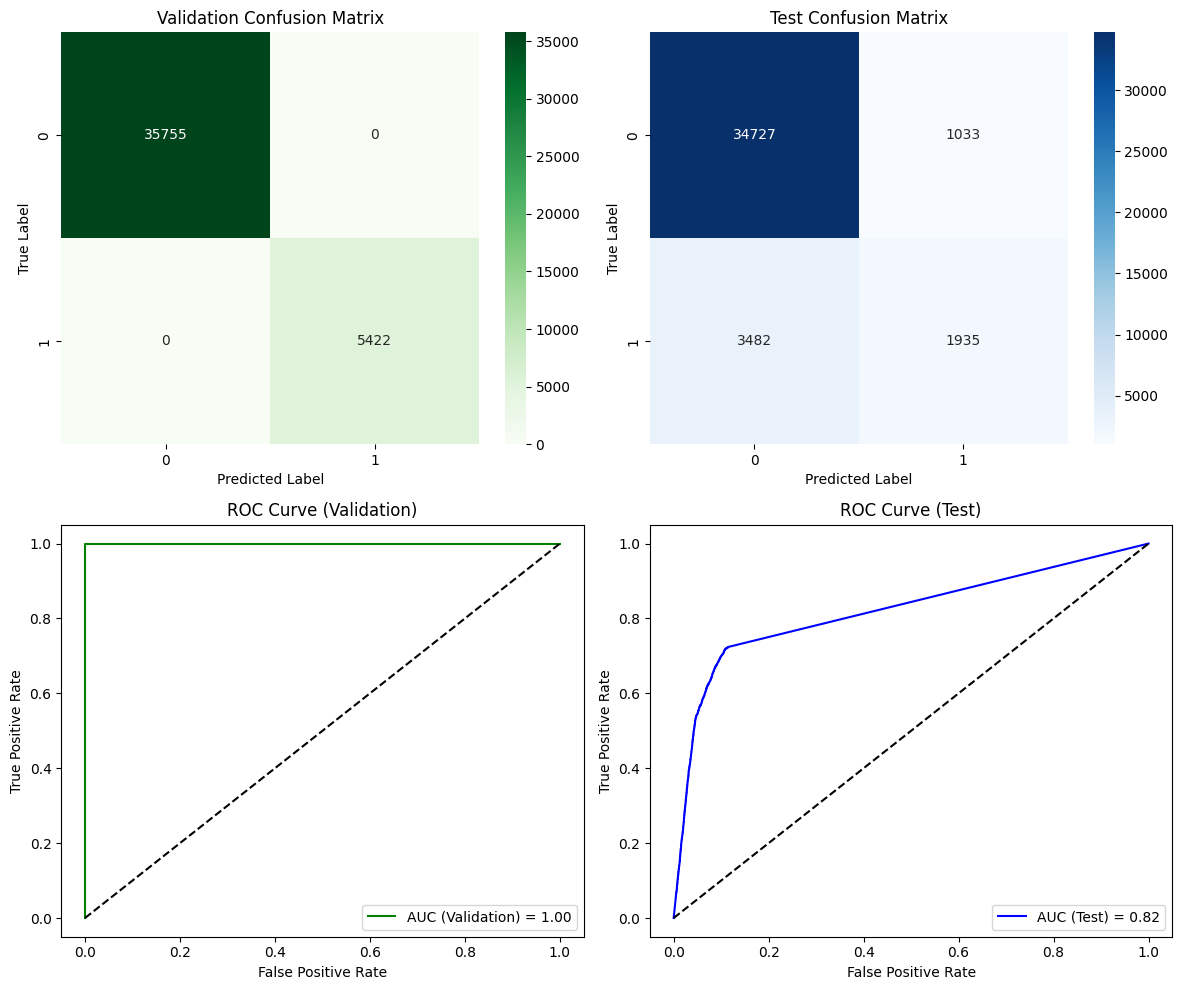

            Accuracy  Precision  Recall  F1 Score   AUC  Cohen's Kappa  \
Validation      1.00       1.00    1.00      1.00  1.00           1.00   
Test            0.89       0.65    0.36      0.46  0.82           0.41   

            Log Loss   fmi  informedness  markedness  youden j  
Validation      0.00  1.00          1.00        1.00      1.00  
Test            1.55  0.48          0.97        0.56      0.33  


In [33]:
# Drop the 'Day' and 'Time of Day' columns from the DataFrame
KNN_df = df.drop(['Day', 'Time of Day', 'Index'], axis=1)

# FEATURE SELECTION:
KNN_df = KNN_df.drop(['Zinc', 'Month', 'Air Temperature', 'Water Temperature', 'Source', 'Conductivity'], axis=1)
ordinal_features = ['Color']
numerical_features = KNN_df.columns.difference(['Target'] + ordinal_features).tolist()

# Create transformers for each type of preprocessing
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # Default strategy is 'ordinal'
])


numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('num', numerical_transformer, numerical_features)],
    remainder='passthrough'
)

# Create a pipeline that applies the preprocessor and then fits the KNN model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Define the hyperparameters grid
param_grid = {
    'classifier__n_neighbors': [5, 10, 15, 20, 25],
    'classifier__weights': ['uniform', 'distance'],  # Weighting of neighbors
    'classifier__p': [1, 2, 3]  # Range for power parameter for Minkowski distance
}


# Split the dataset into features and the target
X = KNN_df.drop('Target', axis=1)
y = KNN_df['Target']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Perform grid search with cross-validation on the validation set, optimizing for F1 score
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_search.fit(X_val, y_val)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
kappa = cohen_kappa_score(y_test, y_test_pred)
logloss = log_loss(y_test, y_test_prob)
auc = roc_auc_score(y_test, y_test_prob)

# Print the best hyperparameters and evaluation metrics
print("Best Hyperparameters:", best_params)
print("Evaluation Metrics:")
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Cohen\'s Kappa: {kappa:.2f}')
print(f'Log Loss: {logloss:.2f}')
print(f'AUC: {auc:.2f}')

# Plotting all figures in a 2x2 grid
plt.figure(figsize=(12, 10))

# Validation Confusion Matrix
plt.subplot(2, 2, 1)  # First plot in a 2x2 grid
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Test Confusion Matrix
plt.subplot(2, 2, 2)  # Second plot in a 2x2 grid
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Validation ROC Curve
plt.subplot(2, 2, 3)  # Third plot in a 2x2 grid
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr_val, tpr_val, label=f'AUC (Validation) = {roc_auc_score(y_val, y_val_prob):.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Test ROC Curve
plt.subplot(2, 2, 4)  # Fourth plot in a 2x2 grid
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr_test, tpr_test, label=f'AUC (Test) = {roc_auc_score(y_test, y_test_prob):.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Calculate metrics for validation set
tn_val = cm_val[0, 0]
fp_val = cm_val[0, 1]
fn_val = cm_val[1, 0]
tp_val = cm_val[1, 1]


validation_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1 Score": f1_score(y_val, y_val_pred),
    "AUC": roc_auc_score(y_val, y_val_prob),
    "Cohen's Kappa": cohen_kappa_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_prob),
    "fmi": fowlkes_mallows_index(tp_val, fp_val, fn_val),
    "informedness": informedness(tp_val, fp_val, fn_val, tn_val),
    "markedness": markedness(tp_val, fp_val, fn_val, tn_val),
    "youden j": youdens_j_index(tp_val, fp_val, fn_val, tn_val)
}


# Calculate metrics for test set
tn_test = cm_test[0, 0]
fp_test = cm_test[0, 1]
fn_test = cm_test[1, 0]
tp_test = cm_test[1, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "AUC": roc_auc_score(y_test, y_test_prob),
    "Cohen's Kappa": cohen_kappa_score(y_test, y_test_pred),
    "Log Loss": log_loss(y_test, y_test_prob),
    "fmi": fowlkes_mallows_index(tp_test, fp_test, fn_test),
    "informedness": informedness(tp_test, fp_test, fn_val, tn_test),
    "markedness": markedness(tp_test, fp_test, fn_test, tn_test),
    "youden j": youdens_j_index(tp_test, fp_test, fn_test, tn_test)
}

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([validation_metrics, test_metrics], index=['Validation', 'Test'])

# Print metrics
print(metrics_df.round(2))


## Logistic Grid Search

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Optimized Hyperparameters:
{'classifier__C': 0.01}


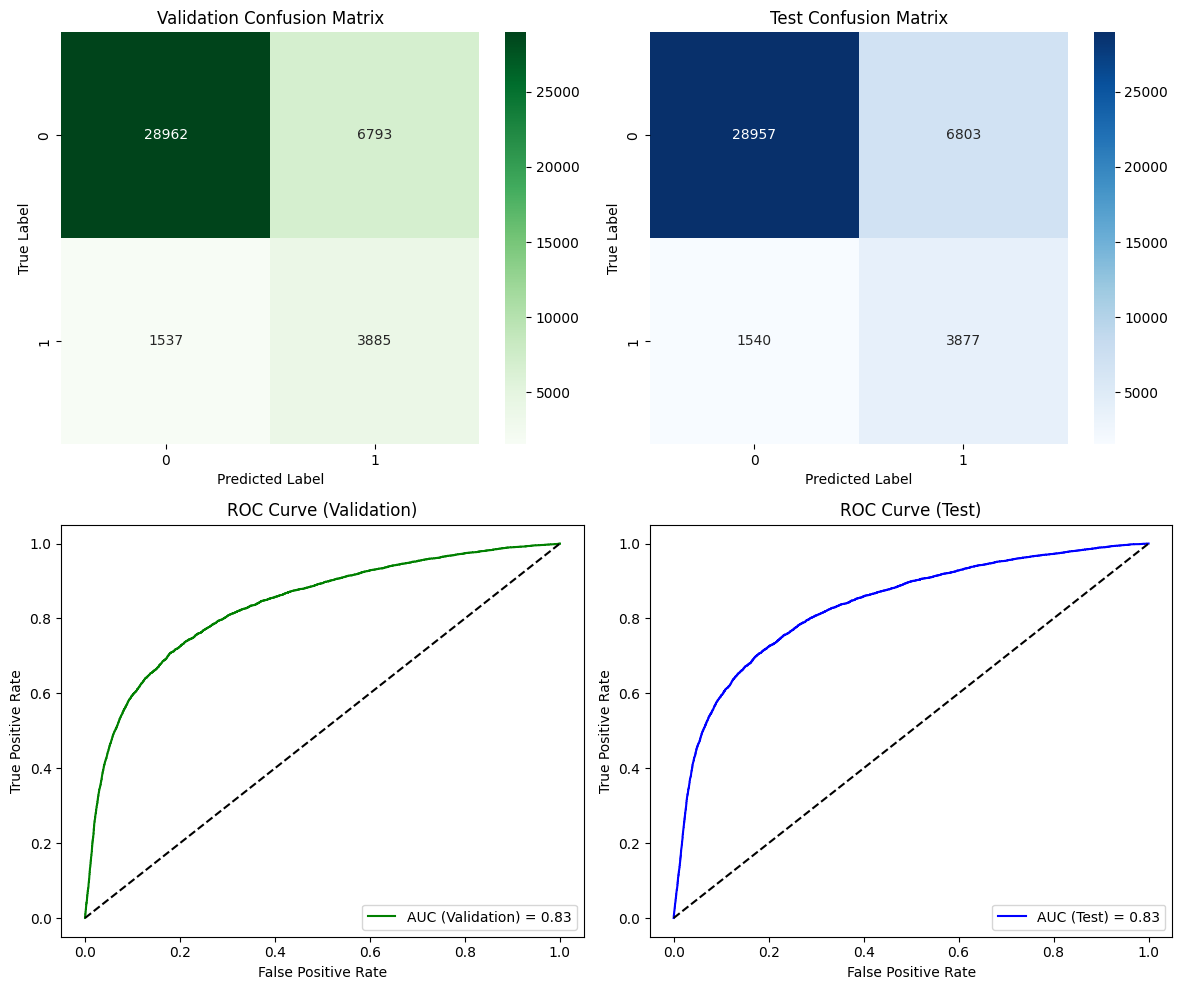

            Accuracy  Precision  Recall  F1 Score   AUC  Cohen's Kappa  \
Validation       0.8       0.36    0.72      0.48  0.83           0.37   
Test             0.8       0.36    0.72      0.48  0.83           0.37   

            Log Loss   fmi  informedness  markedness  youden j  
Validation      0.51  0.51          0.53        0.31      0.53  
Test            0.51  0.51          0.53        0.31      0.53  


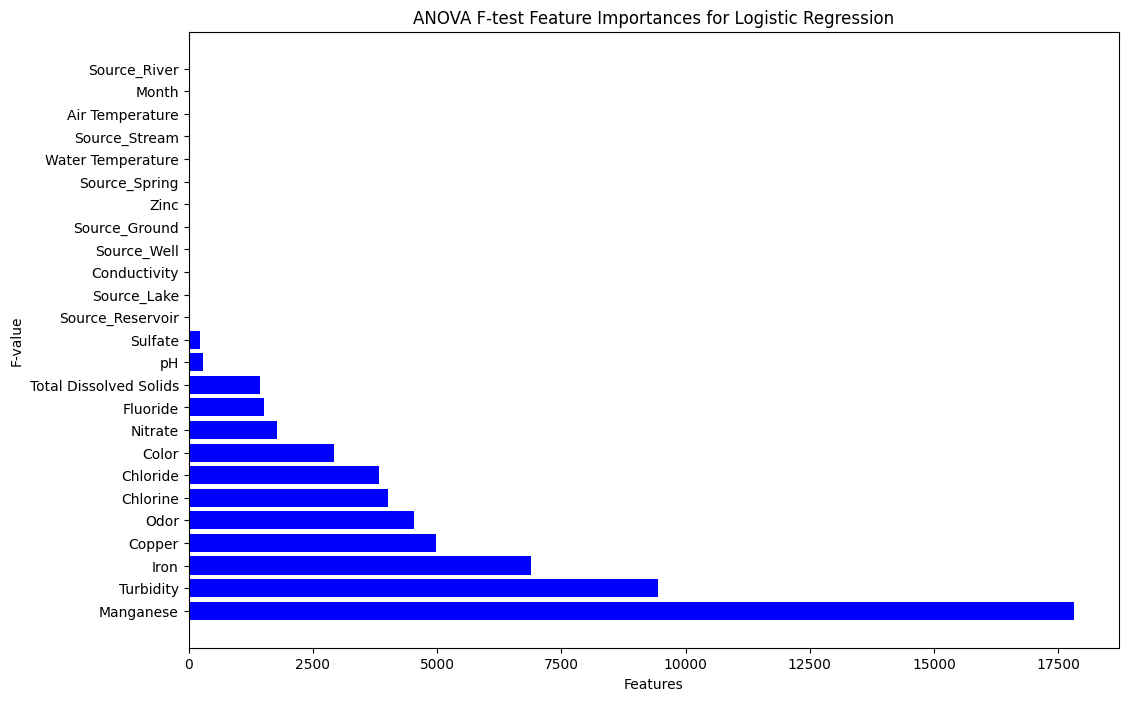

<Figure size 640x480 with 0 Axes>

In [34]:
from sklearn.linear_model import LogisticRegression

# Drop the 'Day' and 'Time of Day' columns from the DataFrame
logistic_df = df.drop(['Day', 'Time of Day', 'Index'], axis=1)

# Define features for different types of encoding
ordinal_features = ['Color', 'Month']
one_hot_features = ['Source']
numerical_features = logistic_df.columns.difference(['Target'] + ordinal_features + one_hot_features).tolist()

# Create transformers for each type of preprocessing
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # Default strategy is 'ordinal'
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a column transformer that applies the transformation to certain columns
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('onehot', categorical_transformer, one_hot_features),
    ('num', numerical_transformer, numerical_features)],
    remainder='passthrough'
)


# Create a pipeline that applies the preprocessor and then fits the logistic regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=5000, class_weight='balanced'))
])

# Define the hyperparameters grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10]  # Covering a range of regularization strength
}

# Split the dataset into features and the target
X = logistic_df.drop('Target', axis=1)
y = logistic_df['Target']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Perform grid search with cross-validation on the validation set, optimizing for F1 score
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_val, y_val)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Print optimized hyperparameters
print("Optimized Hyperparameters:")
print(best_params)

# Plotting all figures in a 2x2 grid
plt.figure(figsize=(12, 10))

# Validation Confusion Matrix
plt.subplot(2, 2, 1)  # First plot in a 2x2 grid
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Test Confusion Matrix
plt.subplot(2, 2, 2)  # Second plot in a 2x2 grid
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Validation ROC Curve
plt.subplot(2, 2, 3)  # Third plot in a 2x2 grid
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr_val, tpr_val, label=f'AUC (Validation) = {roc_auc_score(y_val, y_val_prob):.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Test ROC Curve
auc_test = roc_auc_score(y_test, y_test_prob)
plt.subplot(2, 2, 4)  # Fourth plot in a 2x2 grid
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr_test, tpr_test, label=f'AUC (Test) = {auc_test:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


# Calculate metrics for validation set
tn_val = cm_val[0, 0]
fp_val = cm_val[0, 1]
fn_val = cm_val[1, 0]
tp_val = cm_val[1, 1]


validation_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1 Score": f1_score(y_val, y_val_pred),
    "AUC": roc_auc_score(y_val, y_val_prob),
    "Cohen's Kappa": cohen_kappa_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_prob),
    "fmi": fowlkes_mallows_index(tp_val, fp_val, fn_val),
    "informedness": informedness(tp_val, fp_val, fn_val, tn_val),
    "markedness": markedness(tp_val, fp_val, fn_val, tn_val),
    "youden j": youdens_j_index(tp_val, fp_val, fn_val, tn_val)
}


# Calculate metrics for test set
tn_test = cm_test[0, 0]
fp_test = cm_test[0, 1]
fn_test = cm_test[1, 0]
tp_test = cm_test[1, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "AUC": roc_auc_score(y_test, y_test_prob),
    "Cohen's Kappa": cohen_kappa_score(y_test, y_test_pred),
    "Log Loss": log_loss(y_test, y_test_prob),
    "fmi": fowlkes_mallows_index(tp_test, fp_test, fn_test),
    "informedness": informedness(tp_test, fp_test, fn_val, tn_test),
    "markedness": markedness(tp_test, fp_test, fn_test, tn_test),
    "youden j": youdens_j_index(tp_test, fp_test, fn_test, tn_test)
}

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([validation_metrics, test_metrics], index=['Validation', 'Test'])

# Print metrics
print(metrics_df.round(2))


# # Update the function to handle the remainder and to ensure all feature names are correctly extracted
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer, including transformations and pipelines."""
    feature_names = []
    
    # Loop through each transformer in the column transformer
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'passthrough':
            # Append the feature names directly
            feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            # If a transformer has a 'get_feature_names_out', use it
            feature_names.extend(transformer.get_feature_names_out(columns))
        elif hasattr(transformer, 'named_steps'):
            last_step = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
            if hasattr(last_step, 'get_feature_names_out'):
                feature_names.extend(last_step.get_feature_names_out(columns))
            elif hasattr(last_step, 'get_feature_names'):
                feature_names.extend(last_step.get_feature_names(columns))
            else:
                # If no method is available, use the original column names
                feature_names.extend(columns)
        else:
            # Just add the column names directly if no transformer method is applicable
            feature_names.extend(columns)

    return feature_names

import numpy as np

X_train_transformed = preprocessor.fit_transform(X_train)

# Now perform ANOVA F-test
f_values, p_values = f_classif(X_train_transformed, y_train)

# Get the feature names after transformation, just like before
transformed_feature_names = get_feature_names(preprocessor)

# Plotting the F-values
plt.figure(figsize=(12, 8))
ordering = np.argsort(f_values)[::-1]  # sort features by F-value
plt.title('ANOVA F-test Feature Importances for Logistic Regression')
plt.barh(np.array(transformed_feature_names)[ordering], f_values[ordering], color='blue')
plt.xlabel('Features')
plt.ylabel('F-value')
plt.show()
plt.tight_layout()


## Logistic Grid Search with Feature Selection

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Optimized Hyperparameters:
{'classifier__C': 1}


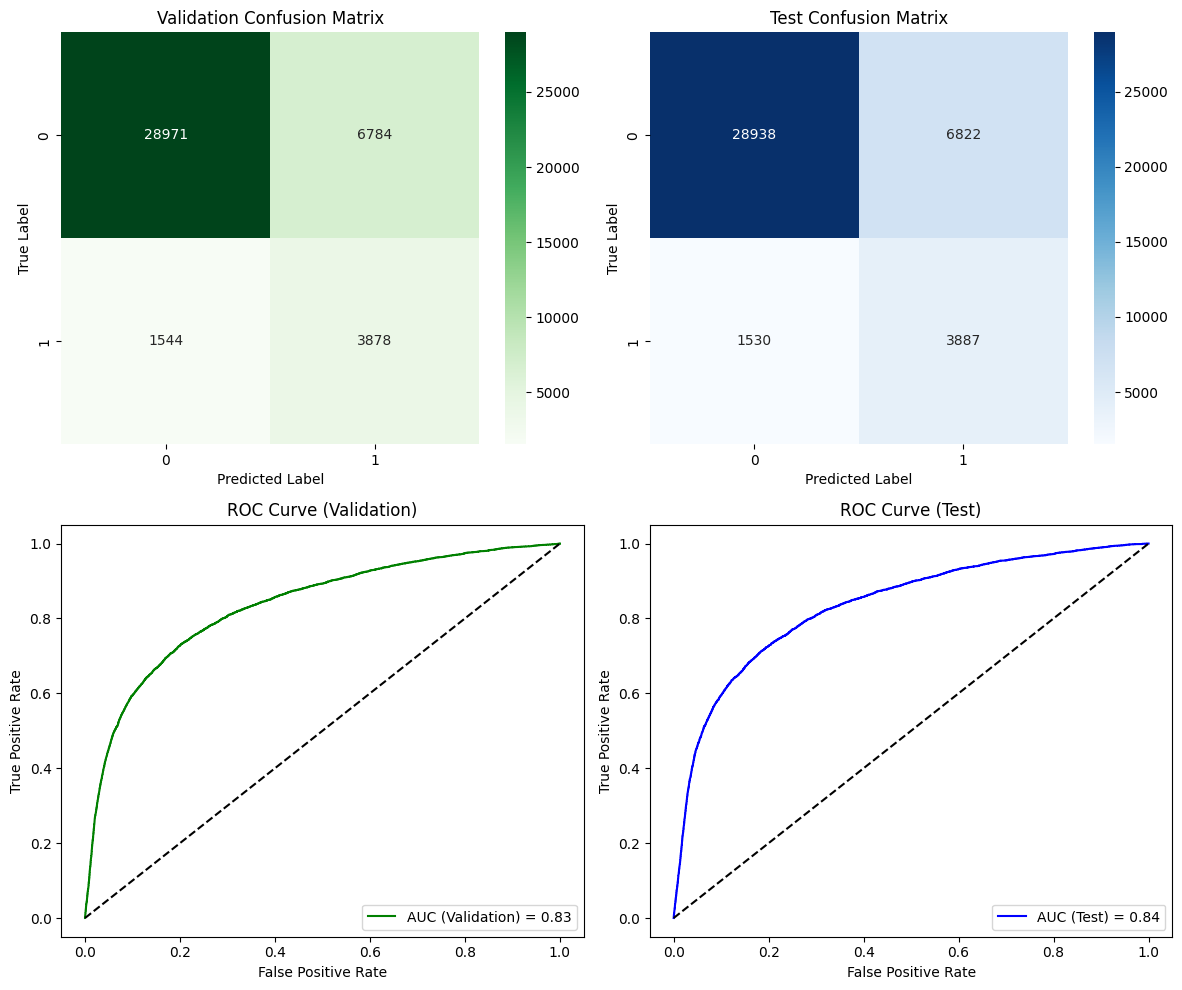

            Accuracy  Precision  Recall  F1 Score   AUC  Cohen's Kappa  \
Validation       0.8       0.36    0.72      0.48  0.83           0.37   
Test             0.8       0.36    0.72      0.48  0.84           0.37   

            Log Loss   fmi  informedness  markedness  youden j  
Validation      0.51  0.51          0.53        0.31      0.53  
Test            0.51  0.51          0.52        0.31      0.53  


In [35]:
# Drop the 'Day' and 'Time of Day' columns from the DataFrame
logistic_df = df.drop(['Day', 'Time of Day', 'Index'], axis=1)

# FEATURE SELECTION:
logistic_df = logistic_df.drop(['Zinc', 'Month', 'Air Temperature', 'Water Temperature', 'Source', 'Conductivity'], axis=1)
ordinal_features = ['Color']
numerical_features = logistic_df.columns.difference(['Target'] + ordinal_features).tolist()

# Create transformers for each type of preprocessing
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # Default strategy is 'ordinal'
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('num', numerical_transformer, numerical_features)],
    remainder='passthrough'
)

# Create a pipeline that applies the preprocessor and then fits the logistic regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=5000, class_weight='balanced'))
])

# Define the hyperparameters grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10]  # Covering a range of regularization strength
}

# Split the dataset into features and the target
X = logistic_df.drop('Target', axis=1)
y = logistic_df['Target']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Perform grid search with cross-validation on the validation set, optimizing for F1 score
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_val, y_val)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Print optimized hyperparameters
print("Optimized Hyperparameters:")
print(best_params)

# Plotting all figures in a 2x2 grid
plt.figure(figsize=(12, 10))

# Validation Confusion Matrix
plt.subplot(2, 2, 1)  # First plot in a 2x2 grid
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Test Confusion Matrix
plt.subplot(2, 2, 2)  # Second plot in a 2x2 grid
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Validation ROC Curve
plt.subplot(2, 2, 3)  # Third plot in a 2x2 grid
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr_val, tpr_val, label=f'AUC (Validation) = {roc_auc_score(y_val, y_val_prob):.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Test ROC Curve
auc_test = roc_auc_score(y_test, y_test_prob)
plt.subplot(2, 2, 4)  # Fourth plot in a 2x2 grid
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr_test, tpr_test, label=f'AUC (Test) = {auc_test:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


# Calculate metrics for validation set
tn_val = cm_val[0, 0]
fp_val = cm_val[0, 1]
fn_val = cm_val[1, 0]
tp_val = cm_val[1, 1]


validation_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1 Score": f1_score(y_val, y_val_pred),
    "AUC": roc_auc_score(y_val, y_val_prob),
    "Cohen's Kappa": cohen_kappa_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_prob),
    "fmi": fowlkes_mallows_index(tp_val, fp_val, fn_val),
    "informedness": informedness(tp_val, fp_val, fn_val, tn_val),
    "markedness": markedness(tp_val, fp_val, fn_val, tn_val),
    "youden j": youdens_j_index(tp_val, fp_val, fn_val, tn_val)
}


# Calculate metrics for test set
tn_test = cm_test[0, 0]
fp_test = cm_test[0, 1]
fn_test = cm_test[1, 0]
tp_test = cm_test[1, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "AUC": roc_auc_score(y_test, y_test_prob),
    "Cohen's Kappa": cohen_kappa_score(y_test, y_test_pred),
    "Log Loss": log_loss(y_test, y_test_prob),
    "fmi": fowlkes_mallows_index(tp_test, fp_test, fn_test),
    "informedness": informedness(tp_test, fp_test, fn_val, tn_test),
    "markedness": markedness(tp_test, fp_test, fn_test, tn_test),
    "youden j": youdens_j_index(tp_test, fp_test, fn_test, tn_test)
}

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([validation_metrics, test_metrics], index=['Validation', 'Test'])

# Print metrics
print(metrics_df.round(2))

## Random Forest Grid Search

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Drop the 'Day' and 'Time of Day' columns from the DataFrame
decision_tree_df = df.drop(['Day', 'Time of Day', 'Index'], axis=1)

# Define features for different types of encoding
ordinal_features = ['Color', 'Month']
one_hot_features = ['Source']
numerical_features = decision_tree_df.columns.difference(['Target'] + ordinal_features + one_hot_features).tolist()

# Create transformers for each type of preprocessing
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # Default strategy is 'ordinal'
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a column transformer that applies the transformation to certain columns
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('onehot', categorical_transformer, one_hot_features),
    ('num', numerical_transformer, numerical_features)],
    remainder='passthrough'
)

# Create a pipeline that applies the preprocessor and then fits the random forest model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=25, class_weight='balanced', random_state=42))
])

# Define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Adjust the number of estimators
    'classifier__max_depth': [None, 10, 15],
    'classifier__min_samples_split': [5, 10, 15],
    'classifier__min_samples_leaf': [2, 4, 6],
    'classifier__max_features': ['sqrt', 'log2'] 
}

# Split the dataset into features and the target
X = decision_tree_df.drop('Target', axis=1)
y = decision_tree_df['Target']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Perform grid search with cross-validation on the validation set, optimizing for F1 score
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)


grid_search.fit(X_val, y_val)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Print optimized hyperparameters
print("Optimized Hyperparameters:")
print(best_params)


# Plotting all figures in a 2x2 grid
plt.figure(figsize=(12, 10))

# Validation Confusion Matrix
plt.subplot(2, 2, 1)  # First plot in a 2x2 grid
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Test Confusion Matrix
plt.subplot(2, 2, 2)  # Second plot in a 2x2 grid
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Validation ROC Curve
plt.subplot(2, 2, 3)  # Third plot in a 2x2 grid
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr_val, tpr_val, label=f'AUC (Validation) = {roc_auc_score(y_val, y_val_prob):.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Test ROC Curve
auc_test = roc_auc_score(y_test, y_test_prob)
plt.subplot(2, 2, 4)  # Fourth plot in a 2x2 grid
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr_test, tpr_test, label=f'AUC (Test) = {auc_test:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Calculate metrics for validation set
tn_val = cm_val[0, 0]
fp_val = cm_val[0, 1]
fn_val = cm_val[1, 0]
tp_val = cm_val[1, 1]


validation_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1 Score": f1_score(y_val, y_val_pred),
    "AUC": roc_auc_score(y_val, y_val_prob),
    "Cohen's Kappa": cohen_kappa_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_prob),
    "fmi": fowlkes_mallows_index(tp_val, fp_val, fn_val),
    "informedness": informedness(tp_val, fp_val, fn_val, tn_val),
    "markedness": markedness(tp_val, fp_val, fn_val, tn_val),
    "youden j": youdens_j_index(tp_val, fp_val, fn_val, tn_val)
}


# Calculate metrics for test set
tn_test = cm_test[0, 0]
fp_test = cm_test[0, 1]
fn_test = cm_test[1, 0]
tp_test = cm_test[1, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "AUC": roc_auc_score(y_test, y_test_prob),
    "Cohen's Kappa": cohen_kappa_score(y_test, y_test_pred),
    "Log Loss": log_loss(y_test, y_test_prob),
    "fmi": fowlkes_mallows_index(tp_test, fp_test, fn_test),
    "informedness": informedness(tp_test, fp_test, fn_val, tn_test),
    "markedness": markedness(tp_test, fp_test, fn_test, tn_test),
    "youden j": youdens_j_index(tp_test, fp_test, fn_test, tn_test)
}

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([validation_metrics, test_metrics], index=['Validation', 'Test'])

# Print metrics
print(metrics_df.round(2))


def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer, including transformations and pipelines."""
    feature_names = []
    
    # Loop through each transformer in the column transformer
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'passthrough':
            # Append the feature names directly
            feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            # If a transformer has a 'get_feature_names_out', use it
            feature_names.extend(transformer.get_feature_names_out(columns))
        elif hasattr(transformer, 'named_steps'):
            last_step = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
            if hasattr(last_step, 'get_feature_names_out'):
                feature_names.extend(last_step.get_feature_names_out(columns))
            elif hasattr(last_step, 'get_feature_names'):
                feature_names.extend(last_step.get_feature_names(columns))
            else:
                # If no method is available, use the original column names
                feature_names.extend(columns)
        else:
            # Just add the column names directly if no transformer method is applicable
            feature_names.extend(columns)

    return feature_names

import numpy as np

X_train_transformed = preprocessor.fit_transform(X_train)

# Now perform ANOVA F-test
f_values, p_values = f_classif(X_train_transformed, y_train)

# Get the feature names after transformation, just like before
transformed_feature_names = get_feature_names(preprocessor)

# Plotting the F-values
plt.figure(figsize=(12, 8))
ordering = np.argsort(f_values)[::-1]  # sort features by F-value
plt.title('ANOVA F-test Feature Importances for Random Forest')
plt.barh(np.array(transformed_feature_names)[ordering], f_values[ordering], color='blue')
plt.xlabel('Features')
plt.ylabel('F-value')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 162 candidates, totalling 810 fits


## Random Forest Grid Search Feature Selection

In [ ]:
# Drop the 'Day' and 'Time of Day' columns from the DataFrame
decision_tree_df = df.drop(['Day', 'Time of Day', 'Index'], axis=1)

# FEATURE SELECTION:
decision_tree_df = df.drop(['Zinc', 'Month', 'Air Temperature', 'Water Temperature', 'Source', 'Conductivity'], axis=1)
ordinal_features = ['Color']
numerical_features = decision_tree_df.columns.difference(['Target'] + ordinal_features).tolist()

# Create transformers for each type of preprocessing
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # Default strategy is 'ordinal'
])


numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_features),
    ('num', numerical_transformer, numerical_features)],
    remainder='passthrough'
)


# Create a pipeline that applies the preprocessor and then fits the random forest model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=25, class_weight='balanced', random_state=42))
])

# Define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Adjust the number of estimators
    'classifier__max_depth': [None, 10, 15],
    'classifier__min_samples_split': [5, 10, 15],
    'classifier__min_samples_leaf': [2, 4, 6],
    'classifier__max_features': ['sqrt', 'log2'] 
}

# Split the dataset into features and the target
X = decision_tree_df.drop('Target', axis=1)
y = decision_tree_df['Target']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation and 50% test

# Perform grid search with cross-validation on the validation set, optimizing for F1 score
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)


grid_search.fit(X_val, y_val)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Print optimized hyperparameters
print("Optimized Hyperparameters:")
print(best_params)

# Plotting all figures in a 2x2 grid
plt.figure(figsize=(12, 10))

# Validation Confusion Matrix
plt.subplot(2, 2, 1)  # First plot in a 2x2 grid
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Test Confusion Matrix
plt.subplot(2, 2, 2)  # Second plot in a 2x2 grid
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Validation ROC Curve
plt.subplot(2, 2, 3)  # Third plot in a 2x2 grid
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr_val, tpr_val, label=f'AUC (Validation) = {roc_auc_score(y_val, y_val_prob):.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Test ROC Curve
auc_test = roc_auc_score(y_test, y_test_prob)
plt.subplot(2, 2, 4)  # Fourth plot in a 2x2 grid
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr_test, tpr_test, label=f'AUC (Test) = {auc_test:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Calculate metrics for validation set
tn_val = cm_val[0, 0]
fp_val = cm_val[0, 1]
fn_val = cm_val[1, 0]
tp_val = cm_val[1, 1]


validation_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1 Score": f1_score(y_val, y_val_pred),
    "AUC": roc_auc_score(y_val, y_val_prob),
    "Cohen's Kappa": cohen_kappa_score(y_val, y_val_pred),
    "Log Loss": log_loss(y_val, y_val_prob),
    "fmi": fowlkes_mallows_index(tp_val, fp_val, fn_val),
    "informedness": informedness(tp_val, fp_val, fn_val, tn_val),
    "markedness": markedness(tp_val, fp_val, fn_val, tn_val),
    "youden j": youdens_j_index(tp_val, fp_val, fn_val, tn_val)
}


# Calculate metrics for test set
tn_test = cm_test[0, 0]
fp_test = cm_test[0, 1]
fn_test = cm_test[1, 0]
tp_test = cm_test[1, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "AUC": roc_auc_score(y_test, y_test_prob),
    "Cohen's Kappa": cohen_kappa_score(y_test, y_test_pred),
    "Log Loss": log_loss(y_test, y_test_prob),
    "fmi": fowlkes_mallows_index(tp_test, fp_test, fn_test),
    "informedness": informedness(tp_test, fp_test, fn_val, tn_test),
    "markedness": markedness(tp_test, fp_test, fn_test, tn_test),
    "youden j": youdens_j_index(tp_test, fp_test, fn_test, tn_test)
}

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([validation_metrics, test_metrics], index=['Validation', 'Test'])

# Print metrics
print(metrics_df.round(2))